# Static Polymer Devolatilization

## 📖 Introduction

Solution, melt, and bulk polymerization processes often include a _physical_ devolatilization (DV) step. In polycondensations, DV occurs alongside polymerization, as removing the condensate is essential for building up the polymer molecular weight. In solution and bulk polymerizations, DV takes place immediately after polymerization to recover the solvent and unreacted monomers, and eliminate [VOC]s. DV can be carried out with _static_ or _rotating_ equipment. In this notebook, we focus on the first type of DV process, using the devolatilization of polystyrene as an example.

![Static devolatilization](devo-polystyrene.png)

This particular DV process consists of two stages. The first is a classic flash operation, where the polymer solution ① is preheated under pressure to maintain its liquid state, then allowed to vaporize in a large-diameter vessel. The second stage builds on this principle but uses water as a stripping agent ⑤ to promote bubble formation in the melt and reduce the partial pressure of the solvent (see note 1) in the vapor phase. Both effects enhance the mass-transfer rate under the very high-viscosity conditions present in the second stage.

A static DV stage is usually modeled on the assumption of phase equilibrium. Deviations from this ideal behavior are addressed by introducing an empirical efficiency factor, rather than explicitly accounting for mass-transfer limitations. 

For a given single equilibrium stage (also known as flash), the steady-state material balances are given by:

\begin{align}
F           &= L + V \\
F \hat{z}_i &= L \hat{x}_i + V \hat{y}_i
\end{align}

where $F$, $L$, and $V$ represent the mass flow rates of the feed, liquid outlet, and vapor oulet, while $\hat{z}_i$, $\hat{x}_i$, and $\hat{y}_i$ denote the mass fraction of component $i$ in these streams (see note 2). For all volatile species, the vapor-liquid equilibrium (VLE) condition is: 

\begin{equation}
P y_i = a_i P^*_i
\end{equation}

where $P$ is the total pressure, $y_i$ is the mole fraction of component $i$ in the vapor phase (related to $\hat{y}_i$), $P^*_i$ is the pure-component vapor pressure of $i$ at the flash temperature $T$, and $a_i$ is the thermodynamic activity of $i$ in the liquid phase. This particular form of the vapor-liquid equilibrium (VLE) condition applies only up to moderate pressures, but that is often an excellent approximation, except in certain high-pressure polyolefin applications. 

The activity of the volatile species in the liquid phase can be estimated with the help of a suitable activity coefficient model or equation of state. A popular choice is the Flory-Huggins activity model, which for a _binary_ solution reads:

\begin{equation}
a_{\mathrm{S}} = \phi_{\mathrm{S}} \exp\left[ \left(1 - \frac{1}{DP} \right) (1 - \phi_{\mathrm{S}}) + \chi (1 - \phi_{\mathrm{S}})^2 \right]
\end{equation}

where $\phi_{\mathrm{S}}$ is the volume fraction of the volatile species (related to $\hat{x}_{\mathrm{S}}$), $DP$ is the degree of polymerization of the polymer, and $\chi$ is the solvent-polymer interaction parameter. Generalizations of this equation are available for [multicomponent] mixtures.

The final equation, which relates the amount of volatiles vaporized to the degree of superheating of the feed, is given by the energy balance:

\begin{equation}
F \sum_i \hat{z}_i \bar{c}_{P,i} (T_{\mathrm{F}} - T) + \dot{Q} = V \sum_i \hat{y}_i \Delta_{\mathrm{vap}} H_i (T)
\end{equation}

where $T_{\mathrm{F}}$ is the feed temperature, $\bar{c}_{P,i}$ is the specific heat capacity of component $i$ in the polymer solution, $\Delta_{\mathrm{vap}} H_i (T)$ is the enthalpy of vaporization of component $i$ at temperature $T$, and $\dot{Q}$ is the heat duty.

When the feed is fully specified, a flash has only two degrees of freedom, no matter how many components are involved. There are different ways to define the flash conditions: if pressure and temperature are given, it's called a PT flash; if pressure and heat duty are specified, it's a PQ flash.

Solving the flash equations for an arbitrary multicomponent mixture can be quite tricky, requiring efficient and robust numerical methods (there are hundreds of papers on this topic). Luckily, the binary and pseudo-binary cases (i.e., with a small amount of water) are straightforward and suffice for our purposes.

In this notebook, we set up and validate a VLE model for styrene-polystyrene solutions, grafically analyze the phase-equilibrium behavior using Pxy and Txy diagrams, and finally carry out PT and PQ flash simulations.

```{note}
1. In polymer solution thermodynamics terminology, the volatile components are often referred to as _solvent(s)_, regardless of their chemical role in the process. For example, in a solution of styrene, ethylbenzene and polystyrene, styrene may be referred to as the solvent, even though it is actually the monomer.
2. In distillation theory, the flash material balances are usually expressed in molar quantities (molar flow rates and molar fractions). In polymer systems, however, molar quantities are ill-defined (or even meaningless), therefore, mass-based (or segment-based) quantities are usually prefered.
3. In _binary_ polymer solutions, the solvent and the polymer are typically assigned the indices 1 and 2, respectively. However, we will not follow this convention to avoid confusion, especially since Python arrays are 0-based.
```

[VOC]: https://en.wikipedia.org/wiki/Volatile_organic_compound
[multicomponent]: https://hugomvale.github.io/polykin/reference/thermo/acm/FloryHuggins_activity/

## ⚛️ Physical Properties

In [1]:
from enum import IntEnum

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import root_scalar

First, we define some helper functions for our calculations: the DIPPR 101 equation for temperature-dependent properties, including vapor pressure correlations, and the Flory-Huggins activity model for binary solutions.

In [2]:
class Idx(IntEnum):
    """Species index."""
    S = 0 # Solvent
    W = 1 # Water
    P = 2 # Polymer

In [ ]:
def dippr_101(
    T: float, A: float, B: float, C: float, D: float, E: float
) -> float:
    """DIPPR equation 101.

    Parameters
    ----------
    T : float
        Temperature (K).
    A : float
        Parameter.
    B : float
        Parameter.
    C : float
        Parameter.
    D : float
        Parameter.
    E : float
        Parameter.

    Returns
    -------
    float
        Property value.
    """
    return np.exp(A + B/T + C*np.log(T) + D*T**E)

In [ ]:
def activity_FH(
    phi_S: float | np.ndarray, chi: float, DP: float,
) -> float | np.ndarray:
    """Flory-Huggins activity model for a binary solution.

    Parameters
    ----------
    phi_S : float
        Solvent volume fraction.
    chi : float
        Interaction parameter.
    DP : float
        Degree of polymerization.

    Returns
    -------
    float | np.ndarray
        Solvent activity.
    """
    return phi_S*np.exp((1 - 1/DP)*(1 - phi_S) + chi*(1 - phi_S)**2)

In [ ]:
def massfrac_to_volfrac(
    w_S: float | np.ndarray, rho: np.ndarray
)-> float | np.ndarray:
    """Convert mass fraction to volume fraction.

    Parameters
    ----------
    w_S : float | np.ndarray
        Solvent mass fraction.
    rho : np.ndarray
        Array of component densities.

    Returns
    -------
    float | np.ndarray
        Solvent volume fraction.
    """
    return (w_S/rho[Idx.S])/(w_S/rho[Idx.S] + (1.0 - w_S)/rho[Idx.P])

We gather all model parameters in a dictionary. For simplicity, the pure-component properties $\rho$, $c_P$ and $\Delta_{\mathrm{vap}} H_i (T)$ are evaluated or estimated at a representative temperature of 200°C.

Since styrene is a self-initiating monomer, measuring the VLE of styrene and polystyrene is impractical. To circumvent this, we assume that styrene behaves similarly to its saturated homolog, ethylbenzene. We take the interaction parameter $\chi$ for this binary from [Vrentas et al. (1983)].

[Vrentas et al. (1983)]: https://doi.org/10.1021/i300010a031

In [ ]:
params = {
    'chi':   0.0,
    'DP':    0.0,
    'MW':    np.zeros(len(Idx)),
    'rho':   np.zeros(len(Idx)),
    'cp':    np.zeros(len(Idx)),
    'DHvap': np.zeros(len(Idx)),
    'Psat':  [lambda T: 0.0]*len(Idx)
}

params['chi'] = 0.35  # polystyrene-ethylbenzene, Vrentas et al. (1983)
params['DP'] = 1e3    # for long chains, the DP value is unimportant

params['MW'][Idx.S] = 104.15 # g/mol
params['MW'][Idx.W] = 18.02  # g/mol
params['MW'][Idx.P] = params['MW'][Idx.S] * params['DP']

params['rho'][Idx.P] = 930.  # kg/m³
params['rho'][Idx.S] = 720.  # kg/m³
params['rho'][Idx.W] = 870.  # kg/m³

params['cp'][Idx.P] = 2.0e3  # J/(kg·K)
params['cp'][Idx.S] = 2.3e3  # J/(kg·K)
params['cp'][Idx.W] = 5.2e3  # J/(kg·K)

params['DHvap'][Idx.S] = 320e3  # J/kg
params['DHvap'][Idx.W] = 1940e3 # J/kg

params['Psat'][Idx.S] = lambda T: 1e-5*dippr_101(T + 273.15, A=1.0593e2, B=-8.6859e3,
                                                 C=-1.2420e1, D=7.5583e-6, E=2.0)
params['Psat'][Idx.W] = lambda T: 1e-5*dippr_101(T + 273.15, A=7.3649e1, B=-7.2582e3,
                                                 C=-7.3037e0, D=4.1653e-6, E=2.0)

For any serious work, it is essential to evaluate the quality of the phase-equilibrium model against experimental data. For this purpose, we digitized Figure 1 of [Vrentas et al. (1983)] and made the data available in a CSV file.

In [7]:
vle_data = pd.read_csv('https://raw.githubusercontent.com/HugoMVale/PRE-Notebooks/main/notebooks/12/ethylbenzene-polystyrene-vle.csv', delimiter=";")
vle_data.head()

,T,phi_S,a_S
0,178.0,0.098,0.301
1,178.0,0.119,0.345
2,178.0,0.063,0.199
3,178.0,0.077,0.255
4,178.0,0.038,0.125


To visualize the phase behavior, we plot the experimental VLE data alongside the Flory-Huggins activity model. The function below generates this comparison, helping us assess how well the model describes the data.

In [8]:
def plot_activity(vle_data: pd.DataFrame, params: dict) -> None:
    """Plot experimental VLE data and Flory-Huggins activity model.

    Parameters
    ----------
    vle_data : pd.DataFrame
        Experimental VLE data set.
    params : dict
        Thermodynamic parameters.
    """

    fig, ax = plt.subplots()
    fig.suptitle("VLE Ethylbenzene-Polystyrene")
    fig.tight_layout()

    # Experimental VLE data
    temperatures = vle_data['T'].unique()
    for T in temperatures:
        ɸ_S = vle_data[vle_data['T'] == T]['phi_S'].values
        a_S = vle_data[vle_data['T'] == T]['a_S'].values
        ax.plot(ɸ_S, a_S, 'o', label=f"{T:.0f} °C")

    # Flory-Huggings model
    ɸ_S = np.linspace(0.0, 1.0, num=100+1)
    a_S = activity_FH(ɸ_S, params['chi'], params['DP'])
    ax.plot(ɸ_S, a_S, label="F-H model", color='gray')

    ax.grid(True)
    ax.legend(loc='best')
    ax.set_xlabel("Solvent volume fraction, " + r"$\phi_{\mathrm{S}}$")
    ax.set_ylabel("Solvent activity")

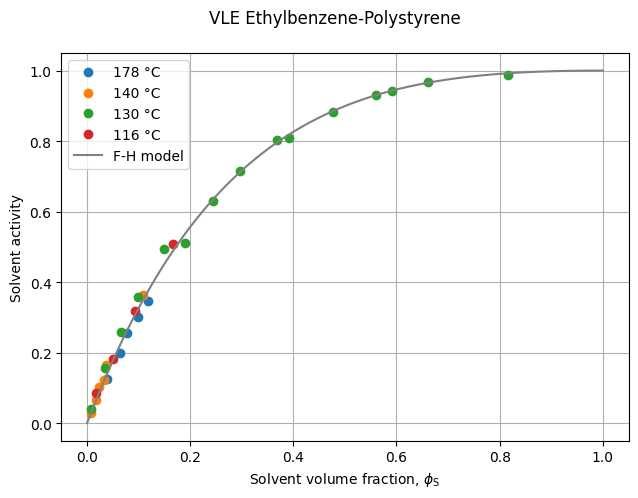

In [9]:
plot_activity(vle_data, params)

The experimental solvent activity data are well described by the Flory-Huggins model with a constant interaction parameter $\chi$. However, this should not be taken as a general rule. In many cases, the interaction parameter depends on both temperature and composition.

## 📈 Pxy diagram

A Pxy diagram is a classical phase equilibrium plot that shows how the equilibrium pressure of a binary mixture varies with composition at a fixed temperature. Polymer solutions exhibit a rather peculiar Pxy diagram due to their strong nonideality and the nonvolatility of the polymer. The function below generates such a plot for our system.

In [ ]:
def plot_Pxy(
    T: list[float],
    params: dict,
    *,
    xw_lines: list[float] = [],
    P_lines: list[float] = [],
) -> None:
    """Plot total pressure as a function of styrene mass fraction and
    temperature.

    Parameters
    ----------
    T : list[float]
        Temperatures (°C).
    params : dict
        Thermodynamic parameters.
    xw_lines : list[float]
        If present, draws vertical lines at these mass fractions.
    P_lines : list[float]
        If present, draws horizontal lines at these pressures (bar).
    """
    fig, ax = plt.subplots()
    fig.tight_layout()

    # Mass and volume fractions
    xw_S = np.geomspace(1e-3, 1.0, num=100+1)
    ɸ_S = massfrac_to_volfrac(xw_S, params['rho'])

    # Saturation pressure
    for i in range(len(T)):
        Psat_S = params['Psat'][Idx.S](T[i])
        a_S = activity_FH(ɸ_S, params['chi'], params['DP'])
        P_S = a_S*Psat_S
        yw_S = P_S/(P_S + 0.0)
        line, = ax.plot(xw_S, P_S, label=f"{T[i]:.0f} °C")
        ax.plot(yw_S, P_S, linestyle="--", color=line.get_color())

    if P_lines:
        for P_line in P_lines:
            ax.axhline(P_line, linestyle=':', color='gray')
    if xw_lines:
        for xw_line in xw_lines:
            ax.axvline(xw_line, linestyle=':', color='gray')

    ax.set_ylabel("Pressure (bar)")
    ax.set_yscale('log')
    ax.set_xlabel("Styrene mass fraction, " r"$\hat{x}$" " or " r"$\hat{y}$")
    ax.set_xscale('log')
    ax.legend(loc='upper left')
    ax.grid(True)

The following call generates a Pxy diagram at three different temperatures (240, 220, and 200°C) and includes auxiliary lines to help analyze the plot.

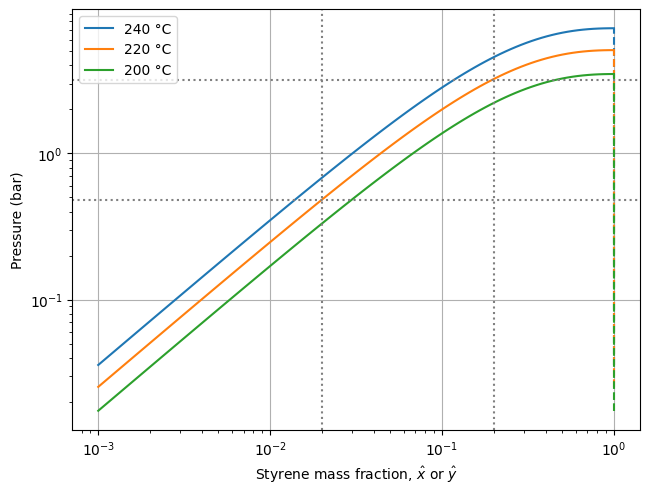

In [11]:
plot_Pxy([240.0, 220.0, 200.0], params, xw_lines=[0.2, 0.02], P_lines=[3.2, 0.48])

The solid lines represent the _bubble_ curves. Above them, the mixture is entirely liquid, while below them, there is a combination of liquid and vapor. The dashed lines represent the _dew_ curves, which appear vertical because the gas phase contains only the solvent (no polymer), regardless of the liquid phase composition.

Take, for instance, a solution with 20 wt% styrene at 220°C. When the pressure is reduced to about 3.2 bar, the solvent begins to vaporize. As the pressure is further reduced, more and more solvent transfers from the liquid to the vapor phase. At any given pressure, the equilibrium composition in both phases is given by the intersection of the horizontal pressure line with the bubble and dew curves. For example, at 0.48 bar, the styrene content in the liquid and vapor phases is 2 wt% and 100 wt%, respectively.

At a given operating pressure, higher temperatures enhance the thermodynamic driving force and accelerate mass transfer due to increased volatile diffusivity and reduced melt viscosity. However, high temperatures also accelerate polymer degradation reactions. Thus, there is an optimal balance. For polystyrene devolatilization, this sweet spot is typically found around 220 ± 20°C.

## 📉 Txy diagram

A Txy diagram serves a similar purpose but focuses on the relationship between equilibrium temperature and composition at a fixed pressure. Again, in polymer solutions, this plot takes on a distinctive form due to the strong nonideality of the solution and the nonvolatility of the polymer. 

From a numerical standpoint, generating a Txy diagram is somewhat more complex than constructing a Pxy diagram, as the relationship between temperature and composition is implicit. Consequently, each point requires the iterative solution of the nonlinear equation $P=a_{\mathrm{S}}(\hat{x}_{\mathrm{S}}) P^*_{\mathrm{S}}(T)$. The function below generates a Txy plot for our system.

In [ ]:
def plot_Txy(
    P: list[float],
    params: dict,
    *,
    xw_lines: list[float] = [],
    T_lines: list[float] = [],
) -> None:
    """Plot temperature as a function of styrene mass fraction and
    total pressure.

    Parameters
    ----------
    P : list[float]
        Pressures (bar).
    params : dict
        Thermodynamic parameters.
    xw_lines : list[float]
        If present, draws vertical lines at these mass fractions.
    T_lines : list[float]
        If present, draws horizontal lines at these temperatures (°C).
    """
    fig, ax = plt.subplots()
    fig.tight_layout()

    def phase_equilibrium(T: float, P: float, ɸ_S: float) -> float:
        a_S = activity_FH(ɸ_S, params['chi'], params['DP'])
        Psat_S = params['Psat'][Idx.S](T)
        return P - a_S*Psat_S

    # Saturation pressure
    xw_S = np.geomspace(1.0, 1e-3, num=50+1)
    T = np.full(xw_S.shape, np.nan)
    for i in range(len(P)):
        x0 = 100.0  # initial guess
        for j in range(len(xw_S)):
            ɸ_S = massfrac_to_volfrac(xw_S[j], params['rho'])
            sol = root_scalar(phase_equilibrium,
                              x0=x0,
                              x1=x0+10.0,
                              args=(P[i], ɸ_S),
                              method='secant')
            T[j] = sol.root
            x0 = sol.root

        yw_S = np.ones_like(T)
        line, = ax.plot(xw_S, T, label=f"{P[i]:.3f} bar")
        ax.plot(yw_S, T, linestyle="--", color=line.get_color())

    if T_lines:
        for T_line in T_lines:
            ax.axhline(T_line, linestyle=':', color='gray')
    if xw_lines:
        for xw_line in xw_lines:
            ax.axvline(xw_line, linestyle=':', color='gray')

    ax.set_ylabel("Temperature (°C)")
    # ax.set_yscale('log')
    ax.set_xlabel("Styrene mass fraction, " r"$\hat{x}$" " or " r"$\hat{y}$")
    ax.set_xscale('log')
    ax.legend(loc='upper right')
    ax.grid(True)

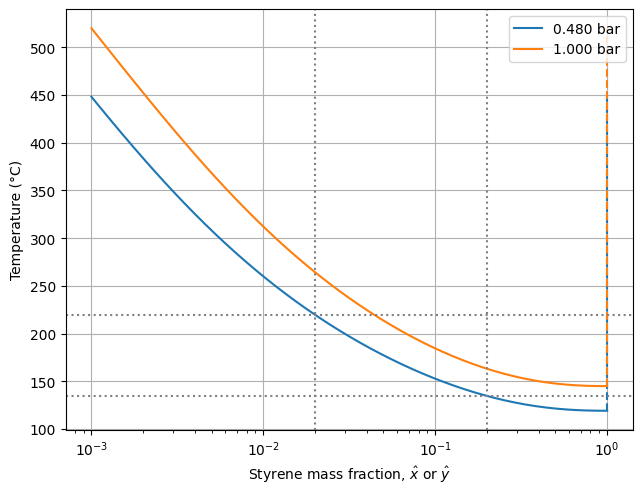

In [13]:
plot_Txy([0.48, 1.0], params, xw_lines=[0.2, 0.02], T_lines=[135.0, 220.0])

As in the Pxy diagram, the solid and dashed lines represent the bubble and dew curves, respectively. Since the polymer is nonvolatile, the temperature tends to infinity as the styrene mass fraction approaches zero.

Consider, for example, a solution with 20 wt% styrene at 0.48 bar. When the temperature rises to approximately 135°C, the solvent begins to vaporize. As the temperature increases further, more solvent transitions from the liquid to the vapor phase. At any given temperature, the equilibrium compositions of both phases are determined by the intersections of the horizontal temperature line with the bubble and dew curves. For instance, at 220°C, the styrene content in the liquid and vapor phases is 2 wt% and 100 wt%, respectively. Of course, this is exactly the same result we obtained earlier from the Pxy diagram.

## ⚗️ Binary Flash

### PT Flash

For a binary polymer solution, the PT flash algorithm is straightforward and works similarly to the procedure used to generate the Txy diagram. The function below handles the calculations.

In [ ]:
def flash2_PT(
    T: float,
    P: float,
    F: float,
    TF: float,
    zw_S: float,
    params: dict
) -> dict[str, float]:
    """PT flash for a binary polymer solution.

    Parameters
    ----------
    T : float
        Temperature (°C).
    P : float
        Pressure (bar).
    F : float
        Feed mass flow rate (kg/s)
    TF : float
        Feed temperature (°C).
    zw_S : float
        Mass fraction of solvent in feed (kg/kg).
    params : dict
        Thermodynamic parameters.

    Returns
    -------
    dict[str, float]
        T, P, Q, L, V, xw_S, yw_S values.
    """

    # Solvent vapor pressure at flash temperature
    Psat_S = params['Psat'][Idx.S](T)

    # Bubble pressure at flash temperature and feed composition
    rho = params['rho']
    aF_S = activity_FH(massfrac_to_volfrac(zw_S, rho),
                       params['chi'], params['DP'])
    P_bubble = Psat_S*aF_S

    # Compute VLE if flash pressure is below the bubble pressure
    if P < P_bubble:

        def phase_equilibrium(xw_S: float) -> float:
            phi_S = massfrac_to_volfrac(xw_S, rho)
            a_S = activity_FH(phi_S, params['chi'], params['DP'])
            y_S = 1.0
            return P*y_S - a_S*Psat_S

        sol = root_scalar(phase_equilibrium,
                          x0=zw_S, # feed composition as initial guess
                          x1=0.0,
                          method='secant')
        
        xw_S = sol.root
        yw_S = 1.0
        V = F*(zw_S - xw_S)/(1 - xw_S)
        L = F - V
    else:
        L = F
        V = 0.0
        xw_S = zw_S
        yw_S = np.nan

    # Energy balance
    hV = params['DHvap'][Idx.S]
    cpF = params['cp'][Idx.S]*zw_S + params['cp'][Idx.P]*(1 - zw_S)
    Q = V*hV - F*cpF*(TF - T)
    
    return {'T': T, 'P': P, 'Q': Q, 'L': L, 'V': V, 'xw_S': xw_S, 'yw_S': yw_S}

Let's flash a "cold" stream with 20 wt% styrene at 0.48 bar and 220°C.

In [15]:
flash2_PT(T=220.0, P=0.48, F=1.0, TF=150.0, zw_S=0.2, params=params)

{'T': 220.0,
 'P': 0.48,
 'Q': np.float64(203007.2709937905),
 'L': np.float64(0.8162272781444047),
 'V': np.float64(0.18377272185559532),
 'xw_S': np.float64(0.019880832923515446),
 'yw_S': 1.0}

As we saw earlier in the Txy and Pxy diagrams, the result is a liquid stream with a styrene content of 2 wt%. To vaporize the solvent and raise the melt temperature from 150°C to 220°C, we need to supply approximately 203 kJ/kg of heat to the system.

### PQ Flash

The PQ flash is solved using the PT flash as a basis, iterating the temperature until the heat duty specification is met. This numerical approach works very well because polymer solutions are wide-boiling-point systems. For narrow-boiling mixtures, it is better to use the vapor fraction as the iterative variable instead.

In [ ]:
def flash2_PQ(
    Q: float,
    P: float,
    F: float,
    TF: float,
    zw_S: float,
    params: dict
) -> dict[str, float]:
    """PQ flash for a binary polymer solution.

    Parameters
    ----------
    Q : float
        Heat duty (J/s).
    P : float
        Pressure (bar).
    F : float
        Feed mass flow rate (kg/s)
    TF : float
        Feed temperature (°C).
    zw_S : float
        Mass fraction of solvent in feed (kg/kg).
    params : dict
        Thermodynamic parameters.

    Returns
    -------
    dict[str, float]
        T, P, Q, L, V, xw_S, yw_S values.
    """

    def heat_specification(T: float) -> float:
        return flash2_PT(T, P, F, TF, zw_S, params)['Q'] - Q
    
    sol = root_scalar(heat_specification,
                      x0=TF,
                      x1=TF+10.0,
                      method='secant')
    T = sol.root
    result = flash2_PT(T, P, F, TF, zw_S, params)

    return result

Let's flash a stream with 20 wt% styrene preheated at 250°C at 0.48 bar under adiabatic conditions.

In [17]:
flash2_PQ(Q=0.0, P=0.48, F=1.0, TF=250.0, zw_S=0.2, params=params)

{'T': np.float64(221.38653194387746),
 'P': 0.48,
 'Q': np.float64(7.275957614183426e-12),
 'L': np.float64(0.8158007993887111),
 'V': np.float64(0.1841992006112889),
 'xw_S': np.float64(0.019368452936735094),
 'yw_S': 1.0}

For this feed with higher energy content, the result is a flash temperature of about 221°C and a residual styrene content of 1.9 wt%.

Let’s make it more visual by creating a plot that shows the effect of the feed temperature on the flash outlet temperature and composition.

In [ ]:
def plot_flash2_PQ(
    Q: float,
    P: float,
    F: float,
    TF: np.ndarray,
    zw_S: float,
    params: dict
) -> None:
    """Plot flash calculations for a binary polymer solution.

    Parameters
    ----------
    Q : float
        Heat duty (J/s).
    P : float
        Pressure (bar).
    F : float
        Feed mass flow rate (kg/s)
    TF : np.ndarray
        Feed temperature (°C).
    zw_S : float
        Mass fraction of solvent in feed (kg/kg).
    params : dict
        Thermodynamic parameters.
    """

    fig, ax = plt.subplots(3, 1, sharex=True)
    fig.suptitle("PQ Flash calculations")
    fig.tight_layout()
    fig.align_ylabels()

    T = np.empty_like(TF)
    L = np.empty_like(TF)
    V = np.empty_like(TF)
    xw_S = np.empty_like(TF)
    yw_S = np.empty_like(TF)

    for i in range(len(TF)):
        result = flash2_PQ(Q, P, F, TF[i], zw_S, params)
        T[i] = result['T']
        L[i] = result['L']
        V[i] = result['V']
        xw_S[i] = result['xw_S']
        yw_S[i] = result['yw_S']

    ax[0].plot(TF, T)
    ax[0].set_ylabel(r"$T$ (°C)")
    ax[0].grid(True)

    ax[1].plot(TF, xw_S)
    ax[1].set_yscale('log')
    ax[1].set_ylim(1e-2, None)
    ax[1].set_ylabel(r"$\hat{x}_{\mathrm{S}}$")
    ax[1].grid(axis='y', which='both')
    ax[1].grid(axis='x', which='major')

    ax[2].plot(TF, V/F)
    ax[2].set_ylabel(r"$V/F$")
    ax[2].grid(True)

    ax[-1].set_xlabel(r"$T_{\mathrm{F}}$ (°C)")

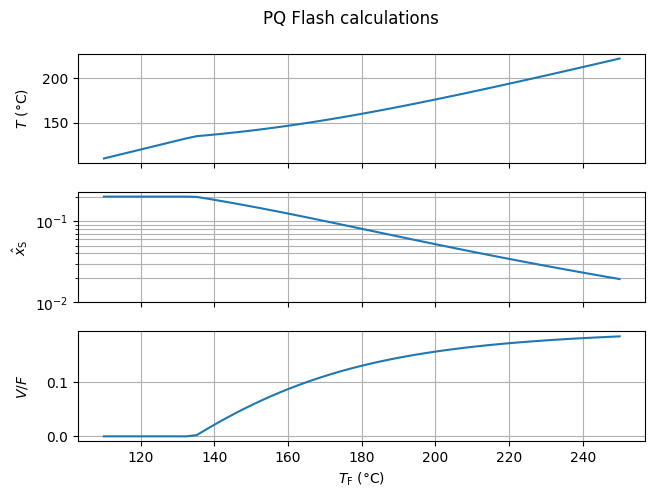

In [19]:
plot_flash2_PQ(Q=0.0, P=0.48,
               F=1.0, TF=np.linspace(110, 250, num=50+1), zw_S=0.2,
               params=params)

Once the feed temperature rises above 135°C (the bubble temperature at flash pressure and feed composition), the solution begins to vaporize. All other factors being constant, a higher feed temperature results in a higher flash temperature and a lower residual styrene content.

In principle, this is all that’s necessary to estimate the minimum temperature and pressure levels required to achieve a given residual styrene content at the outlet of the _first_ polystyrene DV stage. Feel free to experiment with other feed and flash conditions.

## ♨️ Pseudo-Binary Flash

The presence of water in the second DV stage complicates things a bit. Besides having an extra volatile component, the system may now also involve two immiscible liquid phases, since water does not mix with the polymer solution. In general, this leads to a three-phase vapor–liquid–liquid equilibrium (VLLE) problem, which is considerably more difficult to solve than the two-phase binary flash discussed in the previous section.

Fortunately, we are only interested in the case where the added water is fully vaporized (otherwise, the DV stage is not being properly operated). In that particular situation, the bottom stream is a single liquid phase containing only solvent and polymer. This allows for a relatively simple VLE calculation—only slightly more complex than the one used in `flash2_PT`. The function below handles the calculations for a PT flash.

In [ ]:
def flash2W_PT(
    T: float,
    P: float,
    F: float,
    TF: float,
    zw_S: float,
    zw_W: float,
    params: dict
) -> dict[str, float]:
    """PT flash for a binary polymer solution with a small amount of added water.

    Parameters
    ----------
    T : float
        Temperature (°C).
    P : float
        Pressure (bar).
    F : float
        Feed mass flow rate (kg/s)
    TF : float
        Feed temperature (°C).
    zw_S : float
        Mass fraction of solvent in feed (kg/kg).
    zw_W : float
        Mass fraction of water in feed (kg/kg).
    params : dict
        Thermodynamic parameters.

    Returns
    -------
    dict[str, float]
        T, P, Q, L, V, xw_S, xw_W, yw_S, yw_S, values.
    """

    # Solvent and water vapor pressures at flash temperature
    Psat_S = params['Psat'][Idx.S](T)
    Psat_W = params['Psat'][Idx.W](T)

    # Check if feed has water
    has_W = zw_W > 0.0

    # Bubble pressure at flash temperature and feed composition
    rho = params['rho']
    aF_S = activity_FH(massfrac_to_volfrac(zw_S, rho),
                       params['chi'], params['DP'])
    P_bubble = Psat_S*aF_S
    P_bubble += Psat_W if has_W else 0.0

    # Compute VLE if flash pressure is below the bubble pressure
    if P < P_bubble:

        def phase_equilibrium(xw_S: float) -> float:
            phi_S = massfrac_to_volfrac(xw_S, rho)
            a_S = activity_FH(phi_S, params['chi'], params['DP'])
            yw_S = 1 - zw_W*(1 - xw_S)/(zw_S + zw_W - xw_S) if zw_W else 1.0
            MW = params['MW']
            y_S = yw_S/MW[Idx.S]/(yw_S/MW[Idx.S] + (1 - yw_S)/MW[Idx.W])
            return P*y_S - a_S*Psat_S

        sol = root_scalar(phase_equilibrium,
                          x0=zw_S,  # feed composition as initial guess
                          x1=0.0,
                          method='secant')

        xw_S = sol.root
        xw_W = 0.0 # water is assumed to vaporize completely
        yw_S = 1 - zw_W*(1 - xw_S)/(zw_S + zw_W - xw_S) if zw_W else 1.0
        yw_W = 1 - yw_S
        L = F*(1 - zw_S - zw_W)/(1 - xw_S)
        V = F - L
    else:
        L = F
        V = 0.0
        xw_S = zw_S
        xw_W = zw_W
        yw_S = np.nan
        yw_W = np.nan

    # Energy balance
    DHvap = params['DHvap']
    cp = params['cp']
    hV = DHvap[Idx.S]*yw_S + DHvap[Idx.W]*yw_W if V else 0.0   
    cpF = cp[Idx.S]*zw_S + cp[Idx.W]*zw_W + cp[Idx.P]*(1 - zw_S - zw_W)
    Q = V*hV - F*cpF*(TF - T)

    return {'T': T, 'P': P, 'Q': Q, 'L': L, 'V': V, 
            'xw_S': xw_S, 'xw_W': xw_W, 'yw_S': yw_S, 'yw_W': yw_W}

Let's flash the concentrated melt leaving the first stage (assuming 2 wt% styrene at 220 °C) at 20 mbar and 240 °C, with 1 wt% added water.

In [21]:
flash2W_PT(T=240.0, P=20e-3, F=1.0, TF=220.0, zw_S=0.02, zw_W=0.01, params=params)

{'T': 240.0,
 'P': 0.02,
 'Q': np.float64(66515.62153844332),
 'L': np.float64(0.9701386826923647),
 'V': np.float64(0.029861317307635304),
 'xw_S': np.float64(0.00014295140977148567),
 'xw_W': 0.0,
 'yw_S': np.float64(0.6651185914881561),
 'yw_W': np.float64(0.3348814085118439)}

Under these conditions, we could potentially reach low residual styrene contents—though still higher than calculated, due to mass transfer limitations. Feel free to play around with the water content to see how it affects the outcome.

## 🔎 Questions/Extras

1. What is the required outlet temperature of the second pre-heater (i.e., stream ⑥) for the second DV stage to operate at 240 °C?
2. Ignoring mass transfer limitations, thermal degradation, and other non-idealities, what is the advantage of using two or more stages instead of just one?
3. Besides the heat required by the heat exchangers, there is another significant — though implicit — source of energy consumption. Where does it occur? Estimate its magnitude.